# Scenario 2: Cell-cell interaction analysis (CPDB LR pairs, within-spot)

## 1. Prepare data

In [1]:
import stlearn as st
import pandas as pd
import random
# read in visium dataset downloaded from: support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Breast_Cancer_Block_A_Section_2
data = st.Read10X("C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1")
data.var_names_make_unique()

## 2 Preprocessing

### 2.1. filter, normalize, scale & PCA

In [2]:
st.pp.filter_genes(data,min_cells=0.00*data.n_vars)
st.pp.normalize_total(data)
st.pp.log1p(data)
st.pp.scale(data)
st.em.run_pca(data,n_comps=50)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


### 2.2. add morphology information

In [3]:
st.pp.tiling(data,out_path="./temp_tiling",crop_size=40)
st.pp.extract_feature(data)
st.spatial.morphology.adjust(data,use_data='X_pca',radius=50,method="mean")
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca_morphology')

The morphology feature is added to adata.obsm['X_morphology']!
The data adjusted by morphology is added to adata.obsm['X_pca_morphology']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


## 3. Cell-cell interaction analysis

### 3.1 Cell type diversity based on transferred labels

label transfer results added to adata.uns['label_transfer']
predicted label added to adata.obs['predictions'].


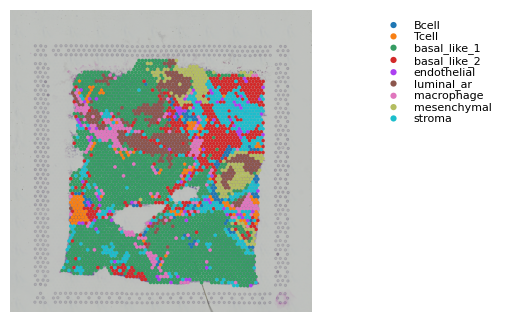

In [5]:
# Read in the spot/cell type predictions based on label transfer
st.add.labels(data, 'label_transfer.csv')
st.pl.cluster_plot(data,use_label="predictions", dpi=100, name='label_transfer', output='.')

Counts for cluster (cell type) diversity stored into adata.uns['cci_het']


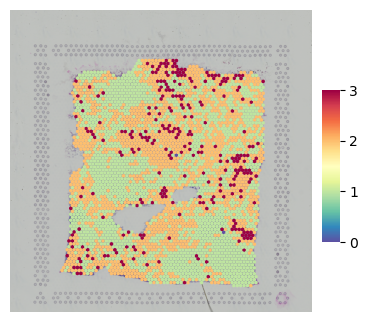

In [6]:
st.tl.cci.het.count(data, distance=0)
st.pl.het_plot(data, use_het='cci_het', dpi=100, name='het_louvain', output='.')

### 3.2 Clustering based on Ligand-Receptor (L-R) co-expression

#### Read in user input LR pair

In [7]:
st.add.lr(adata=data, cpdb_filepath = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1\\cpdb\\means.txt", sep="\t")

cpdb results added to adata.uns['cpdb']
Added ligand receptor pairs to adata.uns['lr'].


#### Calculate the proportion of known ligand-receptor co-expression in the neighbouring spots

Altogether 1554 valid L-R pairs
L-R interactions with neighbours are counted and stored into adata\.uns['cci_lr']


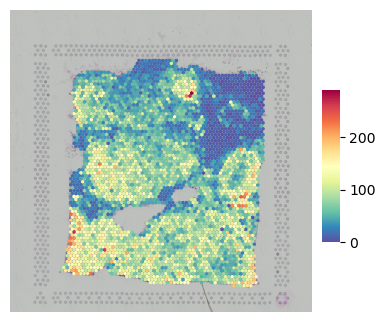

In [8]:
st.tl.cci.base.lr(adata=data, use_data='normalized_total', distance=0)
st.pl.het_plot(data, use_het='cci_lr', dpi=100, name='cci_lr', output='.')

#### Merge cci cell type diversity and L-R coexpression scores

Results of spatial interaction analysis has been written to adata.uns['merged']


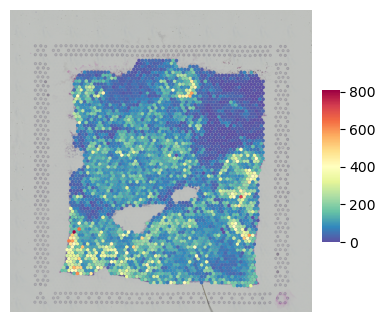

In [9]:
# merge the number of spots belonging to largest lr cci cluster, with the number of different cell types within each window
st.tl.cci.merge(data, use_lr='cci_lr', use_het='cci_het')
st.pl.het_plot(data, use_het='merged', dpi=100, name='merged', output='.')